# Example script to reproduce dark vector flux and SHiP event rate in 2412.01880

This example shows how to 
1. Generate BSM showers from meson sample.
2. Obtain dark vector sample from meson BSM decay.
3. Reproduce dark vector flux plot given certain vector masse and coupling.
4. Reproduce ShiP event rate.

** Note: Here we assume electrons in the target are free and at rest.


## Part I: Dark vector flux plots

### Load dependencies

In [90]:
import numpy as np
import pickle as pk
import os

current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
PETITE_home_dir = os.path.split(parent_path)[0]

dictionary_dir = "/PETITE/data_400GeV/"
import PETITE.physical_constants as ppc
from PETITE import dark_shower as pds
from PETITE import shower as ps
from PETITE import particle as ppr
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt

### Choose vector mass from the list below. We choose $m_V$ = 30MeV in this case.

In [2]:
mV_list = [0.003, 0.010, 0.030, 0.100, 0.300, 1.000]
mV = mV_list[2]

### Create a dark shower object with molybdenum as the target material.

In [3]:
E_cut = 0.95*mV
sMo = pds.DarkShower(PETITE_home_dir+dictionary_dir, "molybdenum", E_cut, mV, kinetic_mixing=1.0)#, Zeff=29.508)

### Generate BSM shower from pion sample

In [4]:
pion_sample = np.load(PETITE_home_dir+"/PETITE/examples/beams/" + "Pi0_400GeVProtons_1e5POT.npy")
E = pion_sample[:,0]
px = pion_sample[:,1]
py = pion_sample[:,2]
pz = pion_sample[:,3]
total_POT = 1e5

# BSM showers are computational intensive, so we will draw a sample of the pion showers for this example
sample_fraction = 0.0003 #drawing 0.03% of the full pion sample
POT = total_POT*sample_fraction # 30 in this case

# Function to choose a sample of the pion showers
def choose_sample(sample_fraction, meson_sample):
    if sample_fraction < 1.0:
        n_to_draw = int(np.random.normal(len(meson_sample)*sample_fraction, np.sqrt(len(meson_sample)*sample_fraction)))
        if n_to_draw > len(meson_sample):
            n_to_draw = len(meson_sample)
            print("Warning: sample size larger than data size, using full data set.")
        choices = np.random.choice(range(len(meson_sample)), n_to_draw, replace=False)
    elif sample_fraction == 1.0:
        choices = range(len(meson_sample))
    
    return choices

choices = choose_sample(sample_fraction, pion_sample)

def return_one_sample(theta):
    i = theta

    p0 = [E[i], px[i], py[i], pz[i]]
    r0 = [0, 0, 0]
    pdict = {"PID":111, "weight":1.0/POT, "stability":"short-lived", 'mass':ppr.m_pi0}
    part0 = ppr.Particle(p0, r0, pdict)
    s0SM = sMo.generate_shower(part0)
    s0BSM = sMo.generate_dark_shower(ExDir=list(s0SM))
    return s0BSM[1]

for i in tqdm(choices):
    s0BSM = return_one_sample(i)
    if i == choices[0]:
        sBSM = s0BSM
    else:
        sBSM = np.concatenate((sBSM, s0BSM), axis=0)

 17%|█▋        | 20/118 [05:34<36:16, 22.21s/it] 

100%|██████████| 118/118 [30:06<00:00, 15.31s/it] 


### Obtain dark vector sample from meson decay

In [5]:
def decay_weight(particle, mV):
    # branching ratios for meson decays m -> V gamma
    mass_ratio = mV/particle.get_ids()["mass"]
    pid = particle.get_ids()["PID"]
    if mass_ratio >= 1.0:
        return 0.0
    else:
        if pid in [111, 221, 331]: # pi0, eta, eta'
            return 2*(1.0 - mass_ratio**2)**3*ppr.meson_twobody_branchingratios[pid]
        elif pid in [223]: # omega
            mM = particle.get_ids()['mass']
            return ((mV**2 - (mM + ppr.m_pi0)**2)*(mV**2 - (mM-ppr.m_pi0)**2))**1.5/((mM**2 - ppr.m_pi0**2)**3)*ppr.meson_twobody_branchingratios[pid]

sample_POT_default = 1e5 # original POT of meson samples
sample_fraction = 0.03 # 3% of the full sample for computational efficiency
POT = sample_POT_default*sample_fraction # effective POT
class MesonSample:
    def __init__(self, meson_directory="/Users/taozhou/Documents/GitHub/PETITE/examples/beams/"):
        # load meson samples
        self._beams = {111:np.load(meson_directory+"Pi0_400GeVProtons_1e5POT.npy"),
                 221:np.load(meson_directory+"Eta_400GeVProtons_1e5POT.npy"),
                 223:np.load(meson_directory+"Omega_400GeVProtons_1e5POT.npy"),
                 331:np.load(meson_directory+"EtaPrime_400GeVProtons_1e5POT.npy")}
        self._NPOT_mesons = POT
        # Choose a fraction of the meson samples
        self._frac_beams = {111:[self._beams[111][i] for i in choose_sample(sample_fraction,self._beams[111])],
                            221:[self._beams[221][i] for i in choose_sample(sample_fraction,self._beams[221])],
                            223:[self._beams[223][i] for i in choose_sample(sample_fraction,self._beams[223])],
                            331:[self._beams[331][i] for i in choose_sample(sample_fraction,self._beams[331])]}
    
    # Function to generate vecter samples from meson decay
    def generate_meson_sample(self, mV, mesons, npermeson=1, meson_info={"mass":ppc.m_pi0, "PID":111, "sample_POT":POT}):
        new_shower = []
        if meson_info['PID'] in [111,221,331] and (mV > meson_info['mass']):
            return []
        if meson_info['PID'] in [223] and (mV > meson_info['mass'] - ppc.m_pi0):
            return []
        for p0 in mesons:
            r0 = [0, 0, 0]
            pdict = {"PID":meson_info['PID'], "mass":meson_info['mass'], "stability":"short-lived", "weight":1/(meson_info['sample_POT']*npermeson)}
            part = ppr.Particle(p0, r0, pdict)
            wg = decay_weight(part, mV)
            V_dict = {"mass":mV, "PID":4900022,
                    "weight":part.get_ids()["weight"]*wg,
                    "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
                    "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
                    "generation_process":"TwoBody_BSMDecay"}
            if meson_info['PID'] in [111, 221, 331]:
                gamma_dict = {"mass":0, "PID":22}
            elif meson_info['PID'] in [223]:
                gamma_dict = {"mass":ppc.m_pi0, "PID":111}
            for jj in range(npermeson):
                    V = part.two_body_decay(gamma_dict, V_dict)[1]
                    new_shower.append(V)
        return new_shower

    def meson_sample(self, mV, PID, n_per_meson=1):
        meson_info = {"mass":ppr.mass_dict[PID], "PID":PID, "sample_POT":self._NPOT_mesons}
        return self.generate_meson_sample(mV, self._frac_beams[PID], npermeson=n_per_meson, meson_info=meson_info)

ms = MesonSample()
# Generate vectors samples from each meson decay
pion_sample_0 = ms.meson_sample(mV=mV, PID = 111, n_per_meson=5)
eta_sample_0 =  ms.meson_sample(mV=mV, PID = 221, n_per_meson=5)
omega_sample_0 = ms.meson_sample(mV=mV, PID = 223, n_per_meson=5)
etap_sample_0 = ms.meson_sample(mV=mV, PID = 331, n_per_meson=5)
meson_sample_0 = np.concatenate([pion_sample_0, eta_sample_0, omega_sample_0, etap_sample_0])
del pion_sample_0, eta_sample_0, omega_sample_0, etap_sample_0
    

### Simple detector efficiency at SHiP

In [6]:
SHiP_Face = 85
SHiP_rT = 4.0

SHiP_info_new = {'detector_range_x':[-2,2], 'detector_range_y':[-3,3], 'detector_face_z':85.0}
SHiP_face_area_cmsq = (4.0*6.0)*(100)**2
def simple_efficiency(th0, detector_geometry=SHiP_info_new, nsamples=5000):
    d = detector_geometry['detector_face_z']
    xmin, xmax = detector_geometry['detector_range_x']
    ymin, ymax = detector_geometry['detector_range_y']

    def samples(phi):
        x = d*np.tan(th0)*np.cos(phi)
        y = -d*np.tan(th0)*np.sin(phi)
        if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
            return 1.0
        else:
            return 0.0

    phi_samples = np.random.uniform(0, 2*np.pi, int(nsamples))
    return np.mean([samples(phi) for phi in phi_samples])

theta_tab = np.linspace(0.0, np.arctan(6.0/85.0), 101)
eff_tab = np.array([simple_efficiency(th0, nsamples=1e5) for th0 in theta_tab])

simple_efficiency_interp = interp1d(theta_tab, eff_tab, kind='linear', fill_value=0.0, bounds_error=False)

### Apply detecter cut, SHiP efficiency to the dark vectors, then bin them in different energies.

In [7]:
# vectors from dark brem 
DB_e = {}
# vectors from dark Compton
DC_e = {}
# vectors from dark annihilation
DA_e = {}
# vectors from meson decay
DD_e = {}

# energy bins
Eb = np.logspace(np.log10(0.030), np.log10(400.0), 61)
Eb = np.append(Eb, 0.0256078)
Eb = np.append(Eb, 468.607)
Eb = np.sort(Eb)

DB_0 = []
DA_0 = []
DC_0 = []
DD_0 = []

for p in sBSM:
    if p.get_ids()['generation_process'] == 'DarkBrem':
        DB_0.append(p)
    elif p.get_ids()['generation_process'] == 'DarkComp':
        DC_0.append(p)
    elif p.get_ids()['generation_process'] == 'DarkAnn':
        DA_0.append(p)

for p in meson_sample_0:
    DD_0.append(p)

DB = ps.detector_cut(DB_0, [SHiP_Face], SHiP_rT, method="Sample", energy_cut=None)[0]
DA = ps.detector_cut(DA_0, [SHiP_Face], SHiP_rT, method="Sample", energy_cut=None)[0]
DC = ps.detector_cut(DC_0, [SHiP_Face], SHiP_rT, method="Sample", energy_cut=None)[0]
DD = ps.detector_cut(DD_0, [SHiP_Face], SHiP_rT, method="Sample", energy_cut=None)[0]

DB_thetas = np.array([np.arctan2(np.sqrt(p.get_p0()[2]**2 + p.get_p0()[1]**2), p.get_p0()[3]) for p in DB])
DA_thetas = np.array([np.arctan2(np.sqrt(p.get_p0()[2]**2 + p.get_p0()[1]**2), p.get_p0()[3]) for p in DA])
DC_thetas = np.array([np.arctan2(np.sqrt(p.get_p0()[2]**2 + p.get_p0()[1]**2), p.get_p0()[3]) for p in DC])
DD_thetas = np.array([np.arctan2(np.sqrt(p.get_p0()[2]**2 + p.get_p0()[1]**2), p.get_p0()[3]) for p in DD])

DB_efficiency_crude = simple_efficiency_interp(DB_thetas)
DA_efficiency_crude = simple_efficiency_interp(DA_thetas)
DC_efficiency_crude = simple_efficiency_interp(DC_thetas)
DD_efficiency_crude = simple_efficiency_interp(DD_thetas)

DB_e_h = np.histogram([p0.get_p0()[0] for p0 in DB], bins=Eb, weights=np.array([p0.get_ids()['weight']/SHiP_face_area_cmsq for p0 in DB])*DB_efficiency_crude)
DA_e_h = np.histogram([p0.get_p0()[0] for p0 in DA], bins=Eb, weights=np.array([p0.get_ids()['weight']/SHiP_face_area_cmsq for p0 in DA])*DA_efficiency_crude)
DC_e_h = np.histogram([p0.get_p0()[0] for p0 in DC], bins=Eb, weights=np.array([p0.get_ids()['weight']/SHiP_face_area_cmsq for p0 in DC])*DC_efficiency_crude)
DD_e_h = np.histogram([p0.get_p0()[0] for p0 in DD], bins=Eb, weights=np.array([p0.get_ids()['weight']/SHiP_face_area_cmsq for p0 in DD])*DD_efficiency_crude)

DB_e[mV] = DB_e_h[0]/np.diff(Eb)
DA_e[mV] = DA_e_h[0]/np.diff(Eb)
DC_e[mV] = DC_e_h[0]/np.diff(Eb)
DD_e[mV] = DD_e_h[0]/np.diff(Eb)


### $\epsilon^2/g_{\alpha \beta}^2$ for leptophilic models

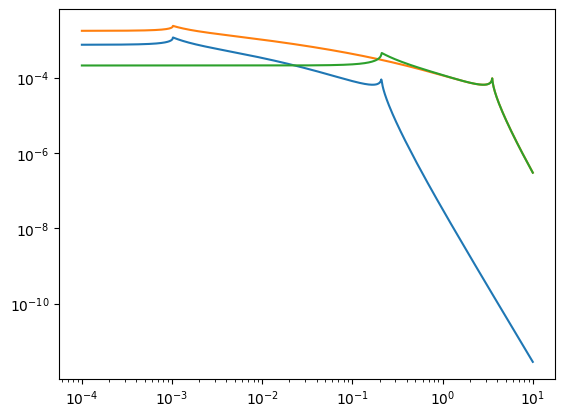

In [8]:
from scipy.interpolate import interp1d
lelmuX, lelmuY = np.transpose(np.loadtxt(PETITE_home_dir+dictionary_dir+"kineticmixing_lelmu.dat"))
leltauX, leltauY = np.transpose(np.loadtxt(PETITE_home_dir+dictionary_dir+"kineticmixing_leltau.dat"))
lmultauX, lmultauY = np.transpose(np.loadtxt(PETITE_home_dir+dictionary_dir+"kineticmixing_lmultau.dat"))

lelmu = interp1d(lelmuX, (4.0*np.pi*ppc.alpha_em)*lelmuY, kind="cubic")
leltau = interp1d(leltauX, (4.0*np.pi*ppc.alpha_em)*leltauY, kind="cubic")
lmultau = interp1d(lmultauX, (4.0*np.pi*ppc.alpha_em)*lmultauY, kind="cubic")

mV_vec = np.logspace(-4, 1, 1001)
plt.plot(mV_vec, lelmu(mV_vec)) #blue
plt.plot(mV_vec, leltau(mV_vec)) #orange
plt.plot(mV_vec, lmultau(mV_vec)) #green
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

### Flux plots as in top row of Fig. 1

In [9]:
# Enable LaTeX rendering
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

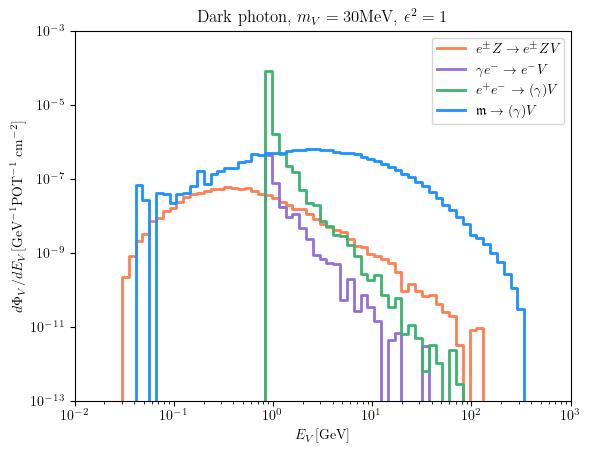

In [10]:
# Flux plot for a secluded dark photon
plt.step(Eb[:-1], DB_e[mV], where='post', lw=2, color="coral", label=r"$e^\pm Z \to e^\pm Z V$")
plt.step(Eb[:-1], DC_e[mV], where='post', lw=2, color="mediumpurple", label=r"$\gamma e^- \to e^- V$")
plt.step(Eb[:-1], DA_e[mV], where='post', lw=2, color="mediumseagreen", label=r"$e^+ e^- \to (\gamma) V$")
plt.step(Eb[:-1], DD_e[mV], where='post', lw=2, color="dodgerblue", label=r"$\mathfrak{m} \to (\gamma) V$")
plt.legend()
plt.title('Dark photon, $m_V=%.0f$MeV, $\epsilon^2=1$'%(mV*1e3))
plt.xlim(1e-2, 1e3)
plt.ylim(1e-13, 1e-3)
plt.xlabel("$E_{V}[\mathrm{GeV}]$")
plt.ylabel("$d \Phi_{V} / d E_{V}[\mathrm{GeV}^{-1} \mathrm{POT}^{-1} \mathrm{~cm}^{-2}]$")
plt.xscale('log')
plt.yscale('log')

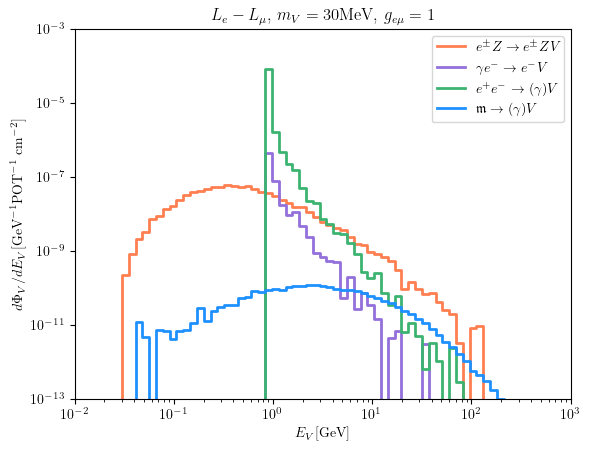

In [11]:
# flux plot for Le-Lmu gauge boson
plt.step(Eb[:-1], DB_e[mV], where='post', lw=2, color="coral", label=r"$e^\pm Z \to e^\pm Z V$")
plt.step(Eb[:-1], DC_e[mV], where='post', lw=2, color="mediumpurple", label=r"$\gamma e^- \to e^- V$")
plt.step(Eb[:-1], DA_e[mV], where='post', lw=2, color="mediumseagreen", label=r"$e^+ e^- \to (\gamma) V$")
plt.step(Eb[:-1], DD_e[mV]*lelmu(mV), where='post', lw=2, color="dodgerblue", label=r"$\mathfrak{m} \to (\gamma) V$")

plt.legend()
plt.title('$L_e-L_\mu$, $m_V=%.0f$MeV, $g_{e\mu}=1$'%(mV*1e3))
plt.xlim(1e-2, 1e3)
plt.ylim(1e-13, 1e-3)
plt.xlabel("$E_{V}[\mathrm{GeV}]$")
plt.ylabel("$d \Phi_{V} / d E_{V}[\mathrm{GeV}^{-1} \mathrm{POT}^{-1} \mathrm{~cm}^{-2}]$")
plt.xscale('log')
plt.yscale('log')

## Part II: Event rate plots

In [ ]:
# probability of vector decay in the decay chamber
def prob_decay_alt(particle_energies, mV, detector_front, detector_length, ctau0):
    gamma = particle_energies/mV
    beta = np.sqrt(1 - 1/gamma**2)
    ctau = ctau0*gamma*beta
    return np.exp(-detector_front/ctau)*(1 - np.exp(-detector_length/ctau))

# R ratio of vectors decay into hadron pairs
RR = np.loadtxt(PETITE_home_dir+dictionary_dir+"RRatio_New.csv", delimiter=",")
Rfn = interp1d(RR.T[0], RR.T[1], fill_value=(0.0, RR[-1][1]), bounds_error=False)

m_had_min = RR[0][0]/2.0

# lifetime and branching ratio of vector decay
def lifetime_brvis(mA, coupling, model="DarkPhoton"):
    if model == "DarkPhoton":
        eps = coupling
        g_l = eps*np.sqrt(4*np.pi*ppc.alpha_em)

        gamma_visible = [1.0e-30]
        gamma_invisible = [1.0e-30]
        lepton_decay_channels = [ppc.m_electron, ppc.m_muon, ppc.m_tau]
        
        for ml in lepton_decay_channels:
            if mA > 2.0*ml:
                gamma_visible.append(1/3*ppc.alpha_em*eps**2*mA*np.sqrt(1.0 - 4*ml**2/mA**2)*(1.0 + 2*ml**2/mA**2))
        if mA > 2.0*m_had_min:
            gamma_visible.append(eps**2*mA/(8*np.pi)*Rfn(mA))
    elif model == "LeLmu" or model == "LeLtau" or model == "LmuLtau":
        g_l = coupling
        if model == "LeLmu":
            epssq = lelmu(mA)*g_l**2
        elif model == "LeLtau":
            epssq = leltau(mA)*g_l**2
        elif model == "LmuLtau":
            epssq = lmultau(mA)*g_l**2

        gamma_visible = [1.0e-30]
        gamma_invisible = [1.0e-30]

        if model == "LeLmu":
            lepton_decay_channels_direct = [ppc.m_electron, ppc.m_muon]
            lepton_decay_channels_indirect = [ppc.m_tau]
        elif model == "LeLtau":
            lepton_decay_channels_direct = [ppc.m_electron, ppc.m_tau]
            lepton_decay_channels_indirect = [ppc.m_muon]
        elif model == "LmuLtau":
            lepton_decay_channels_direct = [ppc.m_muon, ppc.m_tau]
            lepton_decay_channels_indirect = [ppc.m_electron]

        for ml in lepton_decay_channels_direct:
            if mA > 2.0*ml:
                gamma_visible.append(g_l**2*mA/(12.0*np.pi)*np.sqrt(1.0 - 4*ml**2/mA**2)*(1.0 + 2*ml**2/mA**2))
        for ml in lepton_decay_channels_indirect:
            if mA > 2.0*ml:
                gamma_visible.append(1/3*ppc.alpha_em*epssq*mA*np.sqrt(1.0 - 4*ml**2/mA**2)*(1.0 + 2*ml**2/mA**2))

        gamma_invisible.append(g_l**2*mA/(12.0*np.pi))

    lifetime = ppc.hbarc/(np.sum(gamma_invisible)+np.sum(gamma_visible))/100.0
    br_vis = np.sum(gamma_visible)/(np.sum(gamma_invisible)+np.sum(gamma_visible))

    return lifetime, br_vis

In [82]:
SHiP_info_new = {'detector_range_x':[-2,2], 'detector_range_y':[-3,3], 'detector_face_z':83.5}
SHiP_Start = [0.0, 0.0, 33.5]
SHiP_Length = 50.0
SHiP_POT = 6.0e20

def reweight_parentage(parent_PID, mV, model="DarkPhoton"):
    """All samples are generated assuming epsilon (kinetic mixing) = 1
        This function determines the correct model-reweighting to the corresponding model parameter = 1 for different production processes
    """
    if model == "DarkPhoton":
        return 1.0
    elif model == "LeLmu":
        #Vs produced in meson decay and proton bremsstrahlung receive epsilon^2 (kinetic mixing) reweighting
        #Vs produced from electrons/positrons, or muons/antimuons (or compton upscattering) couple directly to g_{e\mu} = 1
        epssq = lelmu(mV)
        if parent_PID in [111, 221, 331, 223, 2212]:
            return epssq
        elif parent_PID in [11, -11, 22, 13, -13]:
            return 1.0/(4.0*np.pi*ppc.alpha_em)

    elif model == "LeLtau":
        #Vs produced in meson decay and proton bremsstrahlung receive epsilon^2 (kinetic mixing) reweighting
        #Vs produced in muon scattering receive epsilon^2 (kinetic mixing) reweighting
        #Vs produced from electrons/positrons (or compton upscattering) couple directly to g_{e\tau} = 1
        epssq = leltau(mV)
        if parent_PID in [111, 221, 331, 223, 2212, 13, -13]:
            return epssq
        elif parent_PID in [11, -11, 22]:
            return 1.0/(4.0*np.pi*ppc.alpha_em)

    elif model == "LmuLtau":
        #Vs produced in meson decay and proton bremsstrahlung receive epsilon^2 (kinetic mixing) reweighting
        #Vs produced in muon scattering couple directly to g_{\mu\tau} = 1
        #Vs produced from electrons/positrons receive epsilon^2 (kinetic mixing) reweighting
        epssq = lmultau(mV)
        if parent_PID in [111, 221, 331, 223, 2212, 11, -11, 22]:
            return epssq
        elif parent_PID in [13, -13]:
            return 1.0/(4.0*np.pi*ppc.alpha_em)


class SHiPSim:
    """Container for SHiP event-rate simulations"""
    def __init__(self,efficiency_directory=PETITE_home_dir+dictionary_dir, 
                geometry=SHiP_info_new):
        self._geometry = geometry
        
        self.setup_efficiency(efficiency_directory)
        self.setup_crude_efficiency()
    
    def setup_efficiency(self, dir):
        efficiency_information = pk.load(open(dir+"SHiP_efficiency_gamma_theta_lifetime_Halloween.pkl", "rb"))
        gamma_vec0, theta_vec0, l_decay_vec0, efficiency_old0, efficiency_new0 = efficiency_information
        del efficiency_information, efficiency_old0

        self._gamma_min, self._gamma_max = gamma_vec0[0], gamma_vec0[-1]
        self._lgamma_vec0 = np.log10(gamma_vec0) #gamma_vec0 was created in log-10 spacing
        #We will interpolate logarithmically with respect to gamma

        self._theta_max = theta_vec0[-1]
        self._l_decay_min, self._l_decay_max = l_decay_vec0[0], l_decay_vec0[-1]

        self._efficiency_new = RegularGridInterpolator((self._lgamma_vec0, theta_vec0, l_decay_vec0), efficiency_new0, fill_value=0)

    def get_efficiency(self):
        return self._efficiency_new

    def SHiP_efficiency(self, particle_list, lifetime):
        gamma_list = np.array([p.get_p0()[0]/p.get_ids()['mass'] for p in particle_list])
        gamma_list = np.where(gamma_list < self._gamma_min, self._gamma_min, gamma_list)
        gamma_list = np.where(gamma_list > self._gamma_max, self._gamma_max, gamma_list)

        theta_list = np.array([np.abs(np.arctan2(np.sqrt(p.get_p0()[2]**2 + p.get_p0()[1]**2), p.get_p0()[3])) for p in particle_list])
        theta_list = np.where(theta_list > self._theta_max, self._theta_max, theta_list)
        
        beta_list = np.sqrt(1 - 1/gamma_list**2)
        l_decay_list = beta_list*gamma_list*lifetime
        l_decay_list = np.where(l_decay_list < self._l_decay_min, self._l_decay_min, l_decay_list)
        l_decay_list = np.where(l_decay_list > self._l_decay_max, self._l_decay_max, l_decay_list)
        
        en = self.get_efficiency()
        return en(np.transpose([np.log10(gamma_list), theta_list, l_decay_list]))

    def crude_efficiency(self, th0, det_geom, nsamples=5000):
        d = det_geom['detector_face_z']
        xmin, xmax = det_geom['detector_range_x']
        ymin, ymax = det_geom['detector_range_y']

        def samples(phi):
            x = d*np.tan(th0)*np.cos(phi)
            y = -d*np.tan(th0)*np.sin(phi)
            if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                return 1.0
            else:
                return 0.0

        phi_samples = np.random.uniform(0, 2*np.pi, int(nsamples))
        return np.mean([samples(phi) for phi in phi_samples])
    
    def setup_crude_efficiency(self):
        theta_tab = np.linspace(0.0, np.arctan(6.0/85.0), 101)
        eff_tab = np.array([self.crude_efficiency(th0, det_geom=self._geometry, nsamples=1e4) for th0 in theta_tab])
        self._simple_efficiency_interp = interp1d(theta_tab, eff_tab, kind='linear', bounds_error=False, fill_value=0.0)
    def get_efficiency_crude(self):
        return self._simple_efficiency_interp

    def SHiP_efficiency_crude(self, sample):
        thetas = np.array([np.arctan2(np.sqrt(p0.get_p0()[2]**2 + p0.get_p0()[1]**2), p0.get_p0()[3]) for p0 in sample])
        en = self.get_efficiency_crude()
        return np.array([en(th0) for th0 in thetas])

    def get_event_rates(self, sample, coupling, model="DarkPhoton", expPOT=SHiP_POT, particle_energies=None, particle_weights=None, efficiency_mode="full", crude_efficiencies=None):
        mA = sample[0].get_ids()['mass']
        parent_PID = sample[0].get_ids()['parent_PID']
        lifetime, br_vis = lifetime_brvis(mA, coupling, model=model)
        if particle_energies is None:
            particle_energies = np.array([p0.get_p0()[0] for p0 in sample])

        decay_probs = [prob_decay_alt(particle_energies[i], mA, SHiP_Start[2], SHiP_Length, lifetime) for i in range(len(particle_energies))]
        if efficiency_mode == "full":
            sample_efficiencies = self.SHiP_efficiency(sample, lifetime)
        elif efficiency_mode == "crude":
            if crude_efficiencies is not None:
                sample_efficiencies = crude_efficiencies
            else:
                sample_efficiencies = self.SHiP_efficiency_crude(sample)

        sample_prefactor = expPOT*br_vis*coupling**2*reweight_parentage(parent_PID, mA, model=model)

        if particle_weights is None:
            particle_weights = np.array([p0.get_ids()['weight'] for p0 in sample])

        event_rates = np.sum(sample_prefactor*(decay_probs*sample_efficiencies*particle_weights))
        return event_rates

sp = SHiPSim()

### Calculate event rate. We consider detector cut, detector efficiency, and decay probability.

In [ ]:
# load dark vector samples (after detector cut)
DarkBrem_0 = np.array(DB)
DarkAnn_0 = np.array(DA)
DarkComp_0 = np.array(DC)
meson_sample_0 = np.array(DD)

meson_sample_theta0 = np.array([np.arctan2(np.sqrt(p0.get_p0()[2]**2 + p0.get_p0()[1]**2), p0.get_p0()[3]) for p0 in meson_sample_0])
DarkBrem_theta0 = np.array([np.arctan2(np.sqrt(p0.get_p0()[2]**2 + p0.get_p0()[1]**2), p0.get_p0()[3]) for p0 in DarkBrem_0])
DarkAnn_theta0 = np.array([np.arctan2(np.sqrt(p0.get_p0()[2]**2 + p0.get_p0()[1]**2), p0.get_p0()[3]) for p0 in DarkAnn_0])
DarkComp_theta0 = np.array([np.arctan2(np.sqrt(p0.get_p0()[2]**2 + p0.get_p0()[1]**2), p0.get_p0()[3]) for p0 in DarkComp_0])

meson_sample_crude_efficiency = simple_efficiency_interp(meson_sample_theta0)
DarkBrem_crude_efficiency = simple_efficiency_interp(DarkBrem_theta0)
DarkAnn_crude_efficiency = simple_efficiency_interp(DarkAnn_theta0)
DarkComp_crude_efficiency = simple_efficiency_interp(DarkComp_theta0)

meson_sample_j = meson_sample_0[np.where(meson_sample_crude_efficiency > 0.0, True, False)]
DarkBrem = DarkBrem_0[np.where(DarkBrem_crude_efficiency > 0.0, True, False)]
DarkAnn = DarkAnn_0[np.where(DarkAnn_crude_efficiency > 0.0, True, False)]
DarkComp = DarkComp_0[np.where(DarkComp_crude_efficiency > 0.0, True, False)]

meson_sample_crude_efficiency = meson_sample_crude_efficiency[np.where(meson_sample_crude_efficiency > 0.0, True, False)]
DarkBrem_crude_efficiency = DarkBrem_crude_efficiency[np.where(DarkBrem_crude_efficiency > 0.0, True, False)]
DarkAnn_crude_efficiency = DarkAnn_crude_efficiency[np.where(DarkAnn_crude_efficiency > 0.0, True, False)]
DarkComp_crude_efficiency = DarkComp_crude_efficiency[np.where(DarkComp_crude_efficiency > 0.0, True, False)]
ces = np.array([meson_sample_crude_efficiency, DarkBrem_crude_efficiency, DarkComp_crude_efficiency, DarkAnn_crude_efficiency])

del meson_sample_0, DarkBrem_0, DarkAnn_0, DarkComp_0

epsilon_g_vec = np.logspace(-10, -3, 141)
n = len(epsilon_g_vec)

def er_four_models(epsi, args):
    SHIP_POT = 6.0e20
    samples, pws, pes = args
    eps = epsilon_g_vec[epsi]
    er_DP = sp.get_event_rates(samples, eps, model="DarkPhoton", expPOT=SHIP_POT, particle_weights=pws, particle_energies=pes, efficiency_mode="full", crude_efficiencies=None)
    er_Lemu = sp.get_event_rates(samples, eps, model="LeLmu", expPOT=SHIP_POT, particle_weights=pws, particle_energies=pes, efficiency_mode="full", crude_efficiencies=None)
    er_Letau = sp.get_event_rates(samples, eps, model="LeLtau", expPOT=SHIP_POT, particle_weights=pws, particle_energies=pes, efficiency_mode="full", crude_efficiencies=None)
    er_Lmutau = sp.get_event_rates(samples, eps, model="LmuLtau", expPOT=SHIP_POT, particle_weights=pws, particle_energies=pes, efficiency_mode="full", crude_efficiencies=None)
    return np.array([er_DP, er_Lemu, er_Letau, er_Lmutau]).flatten()

#samples = np.concatenate([meson_sample_j, DarkBrem, DarkComp, DarkAnn])
# meson decay
samples_d = meson_sample_j
pws_d = np.array([p0.get_ids()["weight"] for p0 in samples_d])
pes_d = np.array([p0.get_p0()[0] for p0 in samples_d])
with Pool(4) as p:
    meson_events = list(tqdm(p.imap(partial(er_four_models, args=(samples_d, pws_d, pes_d)), range(n)), total=n))

/Users/taozhou/Documents/GitHub/PETITE/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 141/141 [01:45<00:00,  1.33it/s]


In [115]:
# Dark brem
samples_b = DarkBrem
pws_b = np.array([p0.get_ids()["weight"] for p0 in samples_b])
pes_b = np.array([p0.get_p0()[0] for p0 in samples_b])
with Pool(4) as p:
    brem_events = list(tqdm(p.imap(partial(er_four_models, args=(samples_b, pws_b, pes_b)), range(n)), total=n))

100%|██████████| 141/141 [01:12<00:00,  1.95it/s]


In [116]:
# Dark Compton
samples_c = DarkComp
pws_c = np.array([p0.get_ids()["weight"] for p0 in samples_c])
pes_c = np.array([p0.get_p0()[0] for p0 in samples_c])
with Pool(4) as p:
    comp_events = list(tqdm(p.imap(partial(er_four_models, args=(samples_c, pws_c, pes_c)), range(n)), total=n))

100%|██████████| 141/141 [00:02<00:00, 49.62it/s]


In [118]:
# Dark Annihilation
samples_a = DarkAnn
pws_a = np.array([p0.get_ids()["weight"] for p0 in samples_a])
pes_a = np.array([p0.get_p0()[0] for p0 in samples_a])
with Pool(4) as p:
    anni_events = list(tqdm(p.imap(partial(er_four_models, args=(samples_a, pws_a, pes_a)), range(n)), total=n))

100%|██████████| 141/141 [00:11<00:00, 12.33it/s]


In [123]:
meson_events = np.array(meson_events)
brem_events = np.array(brem_events)
comp_events = np.array(comp_events)
anni_events = np.array(anni_events)

### Plot event rate for different models.

/Users/taozhou/Documents/GitHub/PETITE/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


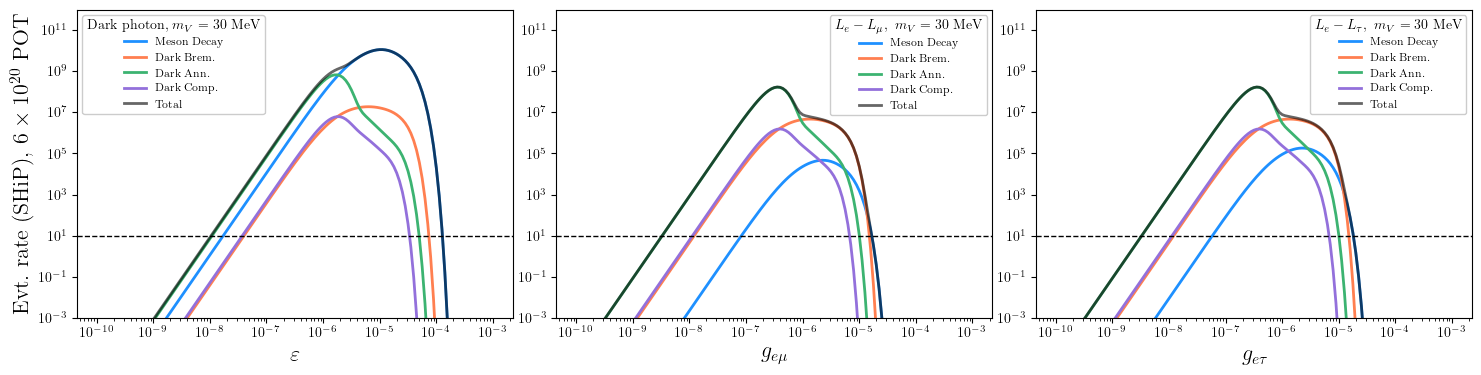

In [134]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
figwid = 18.0
fighei = 4
wwspace = 0.1

fig, axes = plt.subplots(1, 3, figsize=(figwid, fighei))

fig.subplots_adjust(wspace=wwspace)

ax = axes[0]
ax.plot(epsilon_g_vec, meson_events[:,0], color='dodgerblue', lw=2, label=r'$\mathrm{Meson}\ \mathrm{Decay}$')
ax.plot(epsilon_g_vec, brem_events[:,0], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(epsilon_g_vec, anni_events[:,0], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(epsilon_g_vec, comp_events[:,0], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(epsilon_g_vec, meson_events[:,0]+brem_events[:,0]+anni_events[:,0]+comp_events[:,0], color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$\mathrm{Dark\ photon,\ }m_V = %.0f\ \mathrm{MeV}$"%(mV*1e3), title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$\varepsilon$", fontsize=16)
ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }6\times 10^{20}\ \mathrm{POT}$", fontsize=16)

ax = axes[1]
ax.plot(epsilon_g_vec, meson_events[:,1], color='dodgerblue', lw=2, label=r'$\mathrm{Meson}\ \mathrm{Decay}$')
ax.plot(epsilon_g_vec, brem_events[:,1], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(epsilon_g_vec, anni_events[:,1], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(epsilon_g_vec, comp_events[:,1], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(epsilon_g_vec, meson_events[:,1]+brem_events[:,1]+anni_events[:,1]+comp_events[:,1], color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$L_e-L_{\mu},\ m_V = %.0f\ \mathrm{MeV}$"%(mV*1e3), title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$g_{e\mu}$", fontsize=16)

ax = axes[2]
ax.plot(epsilon_g_vec, meson_events[:,2], color='dodgerblue', lw=2, label=r'$\mathrm{Meson}\ \mathrm{Decay}$')
ax.plot(epsilon_g_vec, brem_events[:,2], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(epsilon_g_vec, anni_events[:,2], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(epsilon_g_vec, comp_events[:,2], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(epsilon_g_vec, meson_events[:,2]+brem_events[:,2]+anni_events[:,2]+comp_events[:,2], color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$L_e-L_{\tau},\ m_V = %.0f\ \mathrm{MeV}$"%(mV*1e3), title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$g_{e\tau}$", fontsize=16)
fig.show()